Adapting from "Deep autoencoder" section of https://blog.keras.io/building-autoencoders-in-keras.html

In [634]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt 

In [635]:
import tensorflow as tf
import tensorflow.compat.v1 as tf
# tf.disable_v2_behavior()
tf.disable_v2_behavior()
import tensorflow.compat.v1 as tf

In [636]:
# for convenience, let's write a function for a neural network with 1+ hidden layers
def simple_model(input_layer, widths, hidden_activation, final_activation=None): 
    # first hidden layer
    hidden = Dense(widths[0], activation=hidden_activation)(input_layer)
    
    # add more hidden layers if requested
    for i in range(len(widths)-2):
        hidden = Dense(widths[i+1], activation=hidden_activation)(hidden)
        
    # output layer has last width
    output = Dense(widths[-1], activation=final_activation)(hidden)
    new_model = Model(input_layer, output)
    return new_model

In [637]:
clear_session = True
if clear_session:
    tf.keras.backend.clear_session()

In [638]:
# define an encoder for the MNIST data
input_img = Input(shape=(784,))
encoding_dim = 32 
encoder = simple_model(input_img, [128, 64, encoding_dim], 'relu')

In [639]:
# define a decoder for the MNIST data
encoded_input = Input(shape=(encoding_dim,))
decoder = simple_model(encoded_input, [64, 128, 784], 'relu', 'sigmoid')

In [640]:
# train little regressor to predict labels on images
# the input to the regressor is the low-dimensional representation of the image
input_rep = Input(shape=(encoding_dim,))
labeler = simple_model(input_rep, [20, 11], 'relu', 'softmax')

In [641]:
# need to define the two outputs of the joint model
reconstructed = decoder(encoder(input_img))
label_output = labeler(encoder(input_img))

In [642]:
import tensorflow as tf
import numpy as np

In [643]:
#def custom_loss(y_true, y_pred):
#    unlabeled_boolean = tf.keras.backend.any(tf.math.equal(y_true, -1), axis=1) # one for each example [True, False, False, ...]
#    mask = tf.cast(~unlabeled_boolean, tf.float32) # one for each example [0, 1, 1, ...]

#    loss = tf.keras.losses.categorical_crossentropy(tf.math.abs(y_true), y_pred)
#    masked_loss = loss * mask

#    # returns loss for each example, but unlabeled ones are masked (set to 0)
#    return masked_loss

In [644]:
def custom_cce(y_true, y_pred):
    unlabeled_boolean = tf.keras.backend.any(tf.is_nan(y_true), axis=1) # one for each example [True, False, False, ...]
    mask = tf.cast(~unlabeled_boolean, tf.float32) # one for each example [0, 1, 1, ...]
    
    y_true = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_true)
    loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    
    # returns loss for each example, but unlabeled ones are masked (set to 0)
    masked_loss = loss * mask
    #print(masked_loss.eval())
    
    # to get the average, we only want to divide by the number of labeled examples 
    avg_loss = tf.reduce_sum(masked_loss)/tf.reduce_sum(mask)
    
    return avg_loss

In [645]:
# with tf.Session() as sess:
#     # little test of custom_cce with two three-dimensional data points 
#     test_ytrue = tf.constant([[0, 1, 0], [1, 0, 0]], dtype=tf.float32)
#     test_ypred = tf.constant([[.01, .99, 0], [.97, 0.03, 0]], dtype=tf.float32)
#     test_loss = custom_cce(test_ytrue, test_ypred)
#     print(test_loss.eval())
    
#     # want the first one to output as 0 because it's masked 
#     test_ytrue = tf.constant([[np.nan, np.nan, np.nan], [1, 0, 0]], dtype=tf.float32)
#     test_loss = custom_cce(test_ytrue, test_ypred)
#     print(test_loss.eval())

In [646]:
# not using this is this notebook, but I think this should work for regression 
def custom_mse(y_true, y_pred):
    unlabeled_boolean = tf.keras.backend.any(tf.is_nan(y_true), axis=1) # one for each example [True, False, False, ...]
    mask = tf.cast(~unlabeled_boolean, tf.float32) # one for each example [0, 1, 1, ...]
    
    y_true = tf.where(tf.is_nan(y_true), tf.zeros_like(y_true), y_true)
    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    
    # returns loss for each example, but unlabeled ones are masked (set to 0)
    masked_loss = loss * mask
    #print(masked_loss.eval())
    
    # to get the average, we only want to divide by the number of labeled examples 
    avg_loss = tf.reduce_sum(masked_loss)/tf.reduce_sum(mask)
    
    return avg_loss

In [647]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [648]:
# with tf.Session() as sess:
#     # little test of custom_mse with two three-dimensional data points 
#     test_ytrue = tf.constant([[0, 1, 2], [-1, 2, 3]], dtype=tf.float32)
#     test_ypred = tf.constant([[-.05, 1.1, 2.1], [-0.95, 2, 3.1]], dtype=tf.float32)
#     test_loss = custom_mse(test_ytrue, test_ypred)
#     print(test_loss.eval())
    
#     # want the first one to output as 0 because it's masked 
#     test_ytrue = tf.constant([[np.nan, np.nan, np.nan], [-1, 2, 3]], dtype=tf.float32)
#     test_loss = custom_mse(test_ytrue, test_ypred)
#     print(test_loss.eval())

In [649]:
# this model takes MNIST images as input and outputs two things: the reconstruction of the image & the label of the image
joint_model = Model(input_img, outputs=[reconstructed, label_output])
# need two loss functions: first for the reconstruction error & second for the label error
joint_model.compile(loss=['mean_squared_error',custom_cce],
                    optimizer='adam',
                    metrics=['accuracy'])

In [650]:
# now let's get the data ready to try this 
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [651]:
x_train.shape

(60000, 28, 28)

In [652]:
subset = 2000
x_train = x_train[:subset,:]
y_train = y_train[:subset]
x_test = x_test[:subset,:]
y_test = y_test[:subset]

In [653]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [654]:
from random import sample

In [655]:
# for the sake of experimenting, let's pretend we only have labels for 10% of the training data
num_train = x_train.shape[0]
#
frac_unlabel = 0.97
#
num_unlabeled = int(frac_unlabel*num_train)
print("num labeled training examples: %d" % (num_train-num_unlabeled))
unlabeled_train_ind = sample(range(num_train), num_unlabeled)
y_train_true = y_train.copy()
y_train[unlabeled_train_ind]= 10 # labeled the "unlabeled" data with class 10

num labeled training examples: 60


In [656]:
from tensorflow.keras.utils import to_categorical

In [657]:
# this one-hot encoding is helpful for classification. We have 11 classes (the last one is the dummy unlabeled class)
y_train_categorical = to_categorical(y_train, 11)
y_test_categorical = to_categorical(y_test, 11)
# the unlabeled ones should have a nan so we can find them later and skip them
y_train_categorical[unlabeled_train_ind, -1] = np.nan 

In [658]:
print(y_train[:10])

[10  0 10 10 10 10 10  3 10 10]


In [659]:
y_train_categorical[:10,:]

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., nan]],
      dtype=float32)

In [660]:
# 10 epochs gives you a not-great model, so if you're more patient, you can increase the epochs 
history = joint_model.fit(x_train, [x_train,y_train_categorical],
                          epochs=50, #100
                          batch_size=5000, #256,
                          shuffle=True,
                          validation_data=(x_test, [x_test, y_test_categorical]))

Train on 2000 samples, validate on 2000 samples
Epoch 1/50
2000/2000 [==============================] - 0s 45us/sample - loss: 2.6677 - model_1_loss: 0.2315 - model_2_loss: 2.4362 - model_1_acc: 0.0020 - model_2_acc: 0.2365 - val_loss: 2.5917 - val_model_1_loss: 0.2306 - val_model_2_loss: 2.3611 - val_model_1_acc: 0.0020 - val_model_2_acc: 0.1420
Epoch 2/50
2000/2000 [==============================] - 0s 10us/sample - loss: 2.5380 - model_1_loss: 0.2303 - model_2_loss: 2.3077 - model_1_acc: 0.0015 - model_2_acc: 0.2815 - val_loss: 2.5465 - val_model_1_loss: 0.2292 - val_model_2_loss: 2.3172 - val_model_1_acc: 0.0025 - val_model_2_acc: 0.1900
Epoch 3/50
2000/2000 [==============================] - 0s 10us/sample - loss: 2.4255 - model_1_loss: 0.2289 - model_2_loss: 2.1966 - model_1_acc: 0.0015 - model_2_acc: 0.3110 - val_loss: 2.5014 - val_model_1_loss: 0.2274 - val_model_2_loss: 2.2739 - val_model_1_acc: 0.0025 - val_model_2_acc: 0.2320
Epoch 4/50
2000/2000 [===========================

Epoch 28/50
2000/2000 [==============================] - 0s 10us/sample - loss: 0.3134 - model_1_loss: 0.0698 - model_2_loss: 0.2436 - model_1_acc: 0.0055 - model_2_acc: 0.1230 - val_loss: 1.4411 - val_model_1_loss: 0.0685 - val_model_2_loss: 1.3726 - val_model_1_acc: 0.0110 - val_model_2_acc: 0.5710
Epoch 29/50
2000/2000 [==============================] - 0s 11us/sample - loss: 0.2771 - model_1_loss: 0.0692 - model_2_loss: 0.2078 - model_1_acc: 0.0075 - model_2_acc: 0.1225 - val_loss: 1.4275 - val_model_1_loss: 0.0684 - val_model_2_loss: 1.3591 - val_model_1_acc: 0.0080 - val_model_2_acc: 0.5735
Epoch 30/50
2000/2000 [==============================] - 0s 11us/sample - loss: 0.2459 - model_1_loss: 0.0688 - model_2_loss: 0.1771 - model_1_acc: 0.0065 - model_2_acc: 0.1200 - val_loss: 1.4179 - val_model_1_loss: 0.0683 - val_model_2_loss: 1.3497 - val_model_1_acc: 0.0100 - val_model_2_acc: 0.5795
Epoch 31/50
2000/2000 [==============================] - 0s 11us/sample - loss: 0.2188 - model

In [661]:
joint_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 784)]        0                                            
__________________________________________________________________________________________________
model (Model)                   (None, 32)           110816      input_1[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
model_1 (Model)                 (None, 784)          111568      model[1][0]                      
__________________________________________________________________________________________________
model_2 (Model)                 (None, 11)           891         model[2][0]                

Text(0.5, 1.0, 'labeler loss')

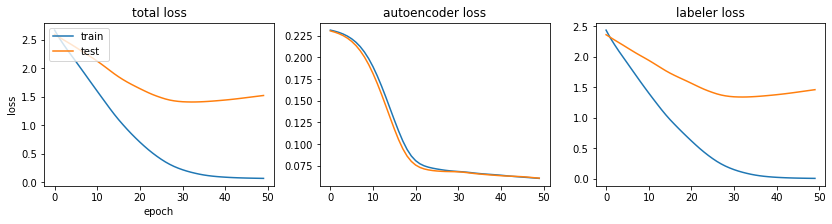

In [662]:
f, ax = plt.subplots(1, 3)
f.set_figwidth(14)
f.set_figheight(3)
ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])
ax[0].set_title('total loss')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'test'], loc='upper left')

ax[1].plot(history.history['model_1_loss'])
ax[1].plot(history.history['val_model_1_loss'])
ax[1].set_title('autoencoder loss')

ax[2].plot(history.history['model_2_loss'])
ax[2].plot(history.history['val_model_2_loss'])
ax[2].set_title('labeler loss')

In [663]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
labeled_imgs = np.argmax(labeler.predict(encoded_imgs), axis=1)

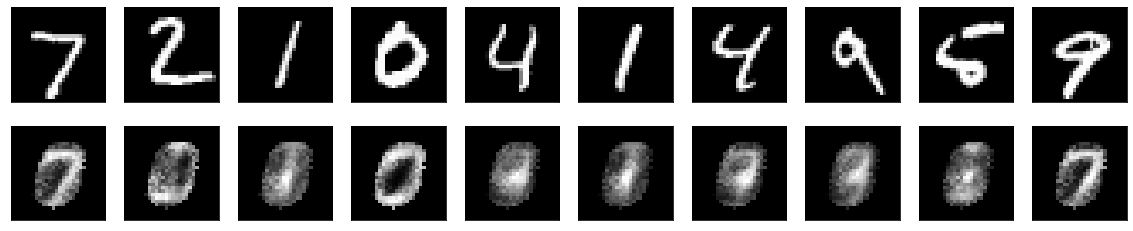

[7 2 1 0 4 1 4 9 5 9]
[7 2 1 0 4 1 9 4 4 7]


In [664]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# also print the true labels for these examples & the predicted labels
print(y_test[:10])
print(labeled_imgs[:10])

In [665]:
# encode training data
encoded_imgs_train = encoder.predict(x_train)
encoded_imgs_test = encoder.predict(x_test)
print(encoded_imgs_train.shape)

(2000, 32)


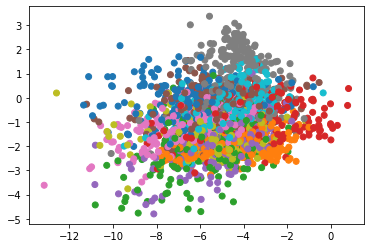

In [666]:
# Here's a scatter plot of the training data projected into the latent space (but just the first two dimensions)
# colored by the class 0-9, so we can already see some clustering in the first two dimensions
plt.scatter(encoded_imgs_train[:,0], encoded_imgs_train[:,1], c=y_train_true, cmap=plt.get_cmap('tab10'))

In [667]:
from mpl_toolkits.mplot3d import Axes3D
#

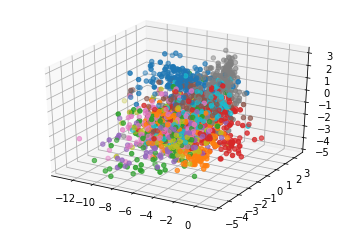

In [668]:
# cool to see the first 3 dimensions as well
plt.figure()
ax = plt.subplot(111, projection='3d')
ax.scatter(encoded_imgs_train[:,0], encoded_imgs_train[:,1], encoded_imgs_train[:,2], c=y_train_true, cmap=plt.get_cmap('tab10'))

In [669]:
from sklearn.metrics import confusion_matrix

In [670]:
labeled_test = np.argmax(labeler.predict(encoded_imgs_test), axis=1)

In [671]:
# the confusion matrix gives us a quick idea of how accurate this is 
confusion_matrix(y_test, labeled_test)

array([[141,   0,   8,   1,   0,   4,   3,  17,   0,   1],
       [  0, 200,   0,   0,  16,   0,   4,   0,  14,   0],
       [  6,   6, 141,   6,  22,   0,   8,   9,  21,   0],
       [ 11,   5,  21,  74,  11,  24,   6,  18,  31,   6],
       [  0,   2,  17,   4, 102,   0,  16,   4,   4,  68],
       [ 12,   1,   6,  17,   9,  93,   1,  14,  19,   7],
       [  3,   0,  35,   0,  28,  16,  84,  11,   1,   0],
       [  1,  11,   6,   4,  10,   0,   1, 142,  10,  20],
       [  5,   6,  15,  32,  12,   7,   8,   9,  96,   2],
       [  2,   1,  11,   7,  26,   0,   5,   6,  19, 117]])